# 이미지 생성 모델

- 이미지 잠재 공간에서 샘플링하여 완전히 새로운 이미지나 기존 이미지를 변형시키는 방식의 주요 기법
  - 변이형 오토인코더(Variational AutoEncoders, VAE)
  
  - 적대적 생성 네트워크(Generative Adversarial Networks, GAN)

- 잠재 공간의 한 포인트를 입력으로 받아 이미지(픽셀의 그리드)를 출력하는 모듈을 VAE에서는 디코더(decoder)라고 함

## 잠재 공간(Latent Space)

<img src="https://images.deepai.org/converted-papers/2007.08383/x1.png">

<sub>[이미지 출처] https://deepai.org/publication/deep-learning-in-protein-structural-modeling-and-design</sub>

# 변이형 오토인코더(Variational AutoEncoders, VAE)

- 입력 이미지를 잠재 공간의 고정된 코딩으로 압축하는 대신  
  이미지를 어떤 통계 분포의 파라미터로 변환 
  
- 평균과 분산 파라미터를 사용하여 이 분포에서 무작위로 하나의 샘플을 추출

- 해당 샘플을 디코딩하여 원본 입력으로 복원

- 위 과정은 안정성을 향상, 잠재 공간 어디에서든 의미있는 표현을 인코딩하게 함

  <img src="https://image.slidesharecdn.com/variationalautoencoder-170601084514/95/variational-autoencoder-21-638.jpg?cb=1496306885">

  <sub>[이미지 출력] https://www.slideshare.net/ssuser06e0c5/variational-autoencoder-76552518</sub>

  <br>

- VAE의 훈련

  - 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실(reconstruction loss)

  - 잠재 공간을 잘 형성하고 훈련 데이터에 과적합을 줄이는 규제 손실(regularization loss)

- VAE 구현의 pseudocode

      z_mean, z_log_var = encoder(input_img)
      
      z = z_mean + exp(0.5 * z_log_var) * epsilon

      recontructed_img = decoder(z)

      model = Model(input_img, reconstructed_img)

      재구성 손실과 규제 손실을 사용하여 훈련
  
  

# Convolutional VAE

- MNIST Dataset

- 코드 참조 : https://www.tensorflow.org/tutorials/generative/cvae?hl=ko

## 모듈 설치

In [136]:
!pip install tensorflow-probability
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1g3o0yui
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-1g3o0yui
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.095bb6495569fa4c812234ac669257d2c091dbb06_-cp36-none-any.whl size=145895 sha256=ebdb4139fb1c837f8458b71380f7535a62d9a3f940195991d568c5cfb5630fc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-q8iyqcc6/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [137]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import numpy as np
import PIL
import time

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.data import Dataset
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, Conv2D, InputLayer
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

## 데이터 로드

In [138]:
(train_images, _), (test_images, _) = mnist.load_data()

In [139]:
print(train_imgaes.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


## 데이터 전처리

In [140]:
def preprocessing_images(images):
  images = images.reshape((images.shape[0], 28, 28,1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

In [141]:
train_images = preprocessing_images(train_images)
test_images = preprocessing_images(test_images)

In [142]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [143]:
train_size = 60000
batch_size = 32
test_size = 10000

## tf.data 를 사용하여 데이터 일괄 처리 및 섞기

In [144]:
train_dataset = (Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset =  (Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

## 인코더, 디코더 모델 구성

- VAE 예제에서는 인코더 및 디코더 네트워크에 두 개의 작은 ConvNet을 사용

- 자세한 네트워크 구성 설명은 링크 참조
 
  - https://www.tensorflow.org/tutorials/generative/cvae?hl=ko

In [154]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim  = latent_dim
    self.encoder = Sequential([InputLayer(input_shape=(28, 28, 1)),
                               Conv2D(filters=32, kernel_size=3,
                                      strides=(2,2), activation='relu'),
                               Conv2D(filters=64, kernel_size=3,
                                      strides=(2,2), activation='relu'),
                               Flatten(),
                               Dense(latent_dim + latent_dim)])
    
    self.decoder = Sequential([InputLayer(input_shape=(latent_dim, )),
                               Dense(units=(7*7*32), activation='relu'),
                               Reshape(target_shape=(7, 7, 32)),
                               Conv2DTranspose(filters=64, kernel_size=3,
                                               strides=2, padding='same',
                                               activation='relu'),
                                Conv2DTranspose(filters=32, kernel_size=3,
                                                strides=2, padding='same',
                                                activation='relu'),
                               Conv2DTranspose(filters=1, kernel_size=3,
                                               strides=1, padding='same')])
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits  = self.decoder(z)

    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## 손실 함수 및 최적화 프로그램 정의

- VAE는 한계 로그 우도에서 증거 하한 (ELBO)을 최대화하여 학습

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

- 실제로 우리는이 기대치의 단일 샘플 Monte Carlo 추정치를 최적화

$$\log p(x| z) + \log p(z) - \log q(z|x),$$




In [155]:
optimizer = Adam(1e-4)

In [163]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(-.5 * ((sample - mean) **2. * tf.exp(-logvar) + logvar +log2pi), axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)

  
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 모델 학습 및 이미지 생성

In [164]:
epochs = 10

latent_dim = 2
num_examples_to_generate = 16


In [165]:
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [166]:
def genereate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
  
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [167]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]


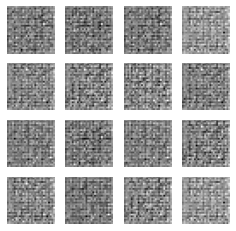

In [168]:
genereate_and_save_images(model, 0, test_sample)

Epoch: 10, Test set ELBO: -156.98910522460938, Time: 4.537564754486084


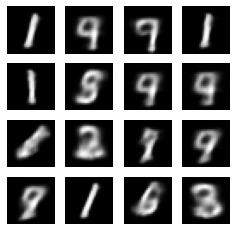

In [169]:
for epoch in range(1, epochs+1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss =tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, Time: {}'.format(epoch, elbo, (end_time-start_time)))
  genereate_and_save_images(model, epoch, test_sample)

## 학습 시각화


- 마지막 훈련 스텝에서 생성 된 이미지 표

In [170]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

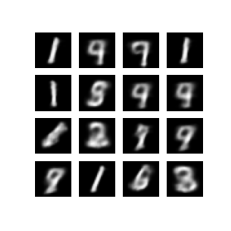

In [171]:
plt.imshow(display_image(epoch))
plt.axis('off')


- 저장된 모든 이미지의 애니메이션 GIF 표시

In [173]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)

  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


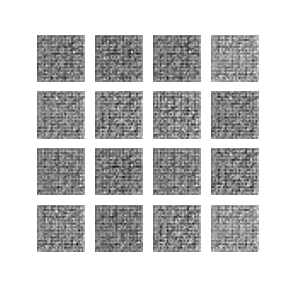

In [174]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

- 잠재 공간에서 2D 다양한 숫자 표시

In [179]:
def plot_latent_images(model, n, digit_size=28):
  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size * n
  iamge_height = image_width
  image = np.zeros((iamge_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i+1) * digit_size,
            j * digit_size: (j+1) * digit_size] = digit.numpy()


  plt.figure(figsize=(10,10))
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

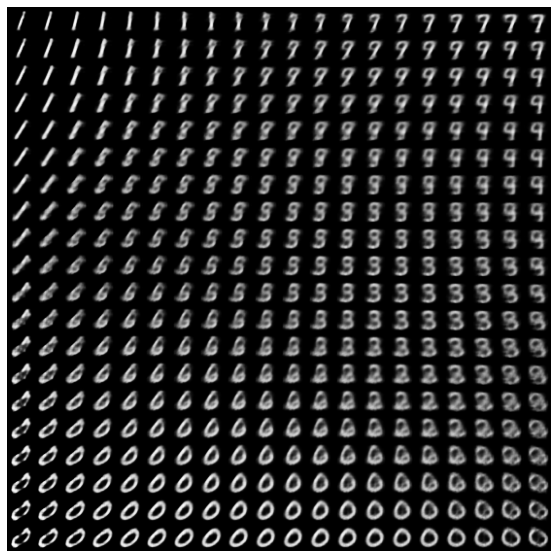

In [180]:
plot_latent_images(model, 20)